In [1]:
import numpy as np

In [2]:
from tensorflow.python._pywrap_record_io import RecordIterator
from tensorflow.core.util import event_pb2
def summary_iterator(path):
    for r in RecordIterator(path, ""):
        yield event_pb2.Event.FromString(r)

In [3]:
def _read_proto_value(node, path: str):
    for p in path.split('.'):
        node = getattr(node, p, None)
        if node is None:
            return None
    return node

In [4]:
from tensorflow.python.framework.dtypes import DType
def _extract_scalar_from_proto(value, step):
        if value.HasField('simple_value'):  # v1
            simple_value = _read_proto_value(value, 'simple_value')
            #print(simple_value)
            yield step, value.tag, simple_value
        elif value.HasField('metadata'):  # v2 eventfile
            if _read_proto_value(value, 'metadata.plugin_data.plugin_name') == 'scalars':
                t = _read_proto_value(value, 'tensor')
                if t:
                    dtype = DType(t.dtype).as_numpy_dtype
                    simple_value = np.frombuffer(t.tensor_content, dtype=dtype)[0]
                    yield step, value.tag, simple_value

In [5]:
def iter_scalar_summary_from_event_file(event_file):
    for event in summary_iterator(event_file):
        step = int(event.step)
        if not event.HasField('summary'):
            continue
        for value in event.summary.value:
            #print(value)
            yield from _extract_scalar_from_proto(value, step=step)

In [6]:
#event_file = '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:1869_2021-03-13_13-53-295885w68_/events.out.tfevents.1615661625.deeplearn11'
event_file = '/home/timchu/data_backup/m3ac-0225-14,19,02,161098-0/events.out.tfevents.1614280747.deeplearn11.1289369.0'
#event_file = '/home/timchu/ray_mbpo/Walker2d/defaults/seed:1797_2021-03-04_15-14-01dhv3tzbw/events.out.tfevents.1614889285.deeplearn11'

In [7]:
events = summary_iterator(event_file) # return iterator tensorflow.core.util.event_pb2.Event
count = 0
last_step = None
for event in events:
    step = event.step
    #print(event.step)
    if not event.HasField('summary'):
        #print('no summary')
        continue
    else:
        values = event.summary.value  #google.protobuf.pyext._message.RepeatedCompositeContainer
        #print('values:', values)
        for value in values:
            pass
            #print(type(value)) # tensorflow.core.framework.summary_pb2.Value
            #print('value:', value)
            #print(value.tag)
            #print(type(value.simple_value))
            
    if step != 0:
        break

In [8]:
def load_event(event_file):
    from collections import defaultdict
    all_data = defaultdict(dict)  # type: ignore
    for step, tag_name, value in iter_scalar_summary_from_event_file(event_file):
            all_data[step][tag_name] = value
    return all_data
all_data = load_event('/home/timchu/data_backup/m3ac-0225-14,19,02,161098-0/events.out.tfevents.1614280747.deeplearn11.1289369.0')
all_data

defaultdict(dict,
            {0: {'Evaluation/EvalCumReward/Average': -1.0951578617095947,
              'Evaluation/EvalCumReward/Median': -1.3680667877197266,
              'Evaluation/EvalCumReward/Std': 3.017033815383911,
              'Evaluation/EvalCumDiscountedReward/Average': -0.8445151448249817,
              'Evaluation/EvalCumDiscountedReward/Median': -0.8637223243713379,
              'Evaluation/EvalCumDiscountedReward/Std': 2.833019733428955,
              'Evaluation/EvalTrajLength/Average': 13.266666412353516,
              'Evaluation/EvalTrajLength/Median': 13.0,
              'Evaluation/EvalTrajLength/Std': 3.997777223587036,
              'Evaluation/EvalStepReturn/Average': -0.05039718747138977,
              'Evaluation/EvalStepReturn/Median': -0.05468012019991875,
              'Evaluation/EvalStepReturn/Std': 0.6398736834526062,
              'ModelVal/transitionError-1/Average': 11.107016563415527,
              'ModelVal/transitionError-1/Median': 8.7995643

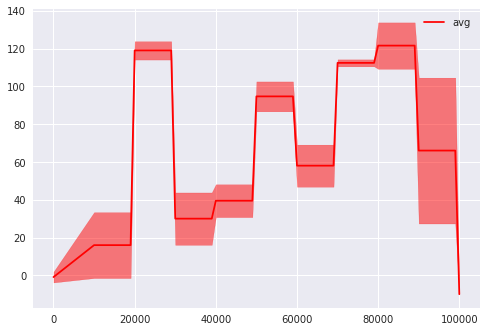

In [9]:
import matplotlib.pyplot as plt

steps = []
avgs = []
uppers = []
lowers = []
for step in all_data.keys():
    #print(step)
    try:
        avg = all_data[step]['Evaluation/EvalCumDiscountedReward/Average']
        std = all_data[step]['Evaluation/EvalCumDiscountedReward/Std']
    except KeyError:
        continue
    finally:
        steps.append(step)
        avgs.append(avg)
        uppers.append(avg + std)
        lowers.append(avg - std)

#print(len(steps), len(avgs), len(stds))

#plt.style.use('ggplot')
plt.style.use('seaborn')
#plt.style.use('seaborn-darkgrid')

plt.plot(steps, avgs, label='avg', color='r')

#plt.plot(steps, uppers, label='upper')
#plt.plot(steps, lowers, label='lower')
plt.fill_between(steps, uppers, lowers, color='r', alpha=0.5)
plt.legend()
#plt.set_facecolor('gray')


In [10]:
hypo1 = {
    'event_files': [
        '/home/timchu/data_backup/m3ac-0225-14,19,02,161098-0/events.out.tfevents.1614280747.deeplearn11.1289369.0',
        '/home/timchu/data_backup/m3ac-0225-12,05,27,920742-0/events.out.tfevents.1614272731.deeplearn11.1269386.0',
        #'/home/timchu/data_backup/m3ac-0225-01,22,52,806219-0/events.out.tfevents.1614234178.deeplearn11.1164198.0',
        #'/home/timchu/data_backup/m3ac-0224-23,47,11,668769-0/events.out.tfevents.1614228435.deeplearn11.1148402.0',
    ],
    'tag': 'General/CumReward/Average', #'General/CumReward/Average', #tune/evaluation/return-average
    'label': 'hypo1',
    'color': 'r'
}
hypo2 = {
    'event_files': [
        #'/home/timchu/data_backup/m3ac-0225-14,19,02,161098-0/events.out.tfevents.1614280747.deeplearn11.1289369.0',
        #'/home/timchu/data_backup/m3ac-0225-12,05,27,920742-0/events.out.tfevents.1614272731.deeplearn11.1269386.0',
        '/home/timchu/data_backup/m3ac-0225-01,22,52,806219-0/events.out.tfevents.1614234178.deeplearn11.1164198.0',
        '/home/timchu/data_backup/m3ac-0224-23,47,11,668769-0/events.out.tfevents.1614228435.deeplearn11.1148402.0',
    ],
    'tag': 'General/CumReward/Average',
    'label': 'hypo2',
    'color': 'b'
}

exp = {
    'hypos': [hypo1, hypo2],
    'title': 'Evaluation in TruncatedAnt Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}

In [11]:
def load_hypo_events(hypo):
    num_run = len(hypo['event_files'])
    events = {}
    setps_set = set()
    for run in range(num_run):
        events[run] = load_event(hypo['event_files'][run])
        #if run == 0:
        #    setps_set = set(events[run].keys())
        #else:
        #    setps_set.intersection(events[run].keys())
    #steps = sorted(list(setps_set))
    return events
#events = load_hypo_events(hypo2)
#events

In [89]:
def get_events_statistics(hypo, events, smooth=None, x_label=None, y_label=None, title=None):
    num_run = len(events)
    data_stack = []
    valid_steps = []
    setps = sorted(events[0].keys())
    for step in setps:
        entry = np.empty(num_run)
        try:
            for run in range(num_run):
                entry[run] = events[run][step][hypo['tag']]
        except KeyError:
            continue
        else:
            #print('add step:', step)
            data_stack.append(entry)
            valid_steps.append(step)
            #print(step, entry)
    data_stack = np.stack(data_stack) #(step, run)
    if smooth:
        for run in range(num_run):
            data_stack[:,run] = np.convolve(data_stack[:,run], np.ones(smooth)/smooth, 'same')
    
    drop_idx = int(np.ceil(smooth/2))
    valid_steps = valid_steps[:-drop_idx]
    mean = data_stack.mean(axis=1)[:-drop_idx]
    std = data_stack.std(axis=1)[:-drop_idx]
    upper = mean + std
    lower = mean - std
    return valid_steps, mean, upper, lower
#valid_steps, mean, upper, lower = get_events_statistics(hypo1, events)

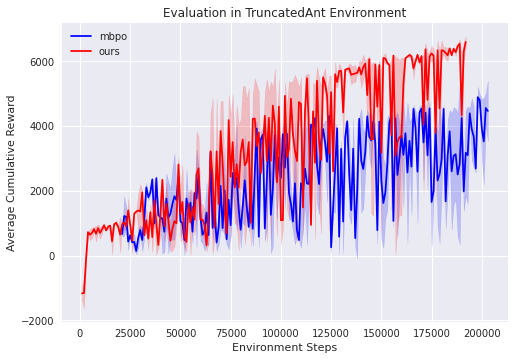

In [18]:
def draw_exp(exp, smooth=1):
    plt.style.use('seaborn')
    #plt.ticklabel_format(axis='x', style='sci', useMathText=True, scilimits=(0,0))
    #plt.axes().xaxis.set_major_locator(plt.MultipleLocator(1 / 1000))
    for hypo in exp['hypos']:
        events = load_hypo_events(hypo)
        valid_steps, mean, upper, lower = get_events_statistics(hypo, events, smooth=smooth)
        plt.plot(valid_steps, mean, label=hypo['label'], color=hypo['color'])
        plt.fill_between(valid_steps, upper, lower, color=hypo['color'], alpha=0.2)
    plt.legend()
    plt.xlabel(exp['xlabel'])
    plt.ylabel(exp['ylabel'])
    plt.title(exp['title'])
    #plt.ticklabel_format(axis='x', style='sci')
    
draw_exp(exp)

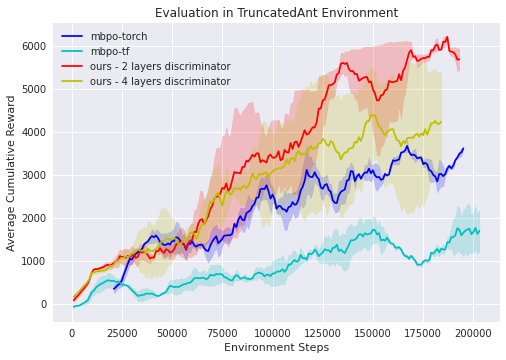

In [134]:
hypo1 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:2353_2021-03-13_13-55-4439sxydu1/events.out.tfevents.1615662417.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:8776_2021-03-13_13-55-55pqnm564f/events.out.tfevents.1615674724.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    #'tag': 'ray/tune/model/val_loss',
    'label': 'mbpo-torch',
    'color': 'b'
}
hypo2 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:1869_2021-03-13_13-53-295885w68_/events.out.tfevents.1615662306.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:8129_2021-03-13_13-53-32osbqvhjx/events.out.tfevents.1615662331.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    #'tag': 'ray/tune/model/val_loss',
    'label': 'mbpo-tf',
    'color': 'c'
}
hypo3 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:6629_2021-03-14_14-52-06hxt5ld_8/events.out.tfevents.1615748419.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:5210_2021-03-14_14-52-1314nivg5_/events.out.tfevents.1615748432.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    #'tag': 'ray/tune/model/val_loss',
    'label': 'ours - 2 layers discriminator',
    'color': 'r'
}
hypo4 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:5677_2021-03-14_16-48-263907kdxv/events.out.tfevents.1615755469.deeplearn11',
        '/mnt/brain1/scratch/timchu/AntTruncatedObs/defaults/seed:5549_2021-03-14_16-48-29a8k8lim2/events.out.tfevents.1615755468.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    #'tag': 'ray/tune/model/val_loss',
    'label': 'ours - 4 layers discriminator',
    'color': 'y'
}

exp = {
    'hypos': [hypo1, hypo2, hypo3, hypo4],
    'title': 'Evaluation in TruncatedAnt Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=15)

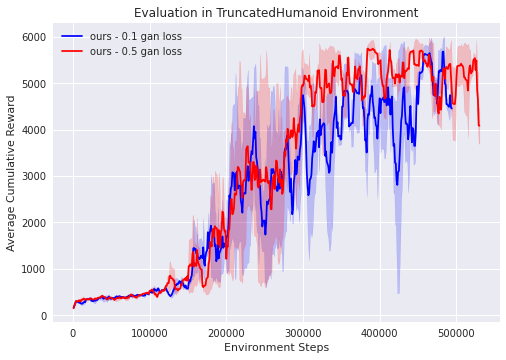

In [158]:
hypo1 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/HumanoidTruncatedObs/defaults/seed:1811_2021-03-16_22-18-59d_9w8nm0/events.out.tfevents.1615948024.deeplearn11',
        '/mnt/brain1/scratch/timchu/HumanoidTruncatedObs/defaults/seed:9377_2021-03-16_22-19-04zazcg1nh/events.out.tfevents.1615948027.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    #'tag': 'ray/tune/model/val_loss',
    'label': 'ours - 0.1 gan loss',
    'color': 'b'
}
hypo2 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/HumanoidTruncatedObs/defaults/seed:7896_2021-03-16_22-19-57l8w10vjy/events.out.tfevents.1615948072.deeplearn11',
        '/mnt/brain1/scratch/timchu/HumanoidTruncatedObs/defaults/seed:7504_2021-03-16_22-20-04d28afbcw/events.out.tfevents.1615948076.deeplearn11'
    ],
    'tag': 'ray/tune/evaluation/return-average',
    #'tag': 'ray/tune/model/val_loss',
    'label': 'ours - 0.5 gan loss',
    'color': 'r'
}

exp = {
    'hypos': [hypo1, hypo2],
    'title': 'Evaluation in TruncatedHumanoid Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Average Cumulative Reward',
}
draw_exp(exp, smooth=7)

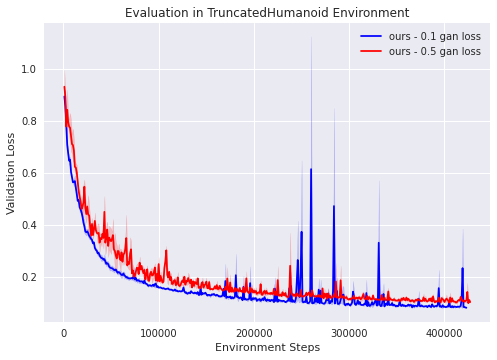

In [151]:
hypo1 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/HumanoidTruncatedObs/defaults/seed:1811_2021-03-16_22-18-59d_9w8nm0/events.out.tfevents.1615948024.deeplearn11',
        '/mnt/brain1/scratch/timchu/HumanoidTruncatedObs/defaults/seed:9377_2021-03-16_22-19-04zazcg1nh/events.out.tfevents.1615948027.deeplearn11'
    ],
    #'tag': 'ray/tune/evaluation/return-average',
    'tag': 'ray/tune/model/val_loss',
    'label': 'ours - 0.1 gan loss',
    'color': 'b'
}
hypo2 = {
    'event_files': [
        '/mnt/brain1/scratch/timchu/HumanoidTruncatedObs/defaults/seed:7896_2021-03-16_22-19-57l8w10vjy/events.out.tfevents.1615948072.deeplearn11',
        '/mnt/brain1/scratch/timchu/HumanoidTruncatedObs/defaults/seed:7504_2021-03-16_22-20-04d28afbcw/events.out.tfevents.1615948076.deeplearn11'
    ],
    #'tag': 'ray/tune/evaluation/return-average',
    'tag': 'ray/tune/model/val_loss',
    'label': 'ours - 0.5 gan loss',
    'color': 'r'
}

exp = {
    'hypos': [hypo1, hypo2],
    'title': 'Evaluation in TruncatedHumanoid Environment',
    'xlabel': 'Environment Steps',
    'ylabel': 'Validation Loss',
}
draw_exp(exp, smooth=1)